In [2]:
!pip install auraloss

  Using cached auraloss-0.4.0-py3-none-any.whl.metadata (8.0 kB)
Using cached auraloss-0.4.0-py3-none-any.whl (16 kB)

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [1]:
from importlib import reload
# Tips to me:
# Use Python 3.11.6
# That's in the location /opt/homebrew/bin/python3

# Libraries
import torch
import torchaudio
import numpy as np
import matplotlib.pyplot as plt
import dataset_creator as dataset
from IPython.display import Audio
from pprint import pprint
import Nets
reload (Nets)
import auraloss

from Nets import complicatedNet, AnotherNet
from torch.nn import functional as F
import models
import model_trainer



In [2]:
reload(dataset)
all_set = dataset.AudioDatasetAt("data/clipses", limit=10000, split_duration=2)
trainset, testset, validationset = dataset.split_dataset(all_set, [0.9, 0.05, 0.1])
# testset = dataset.AudioDatasetAt("datasets/clips/test",limit=200)
# trainset = dataset.AudioDatasetAt("datasets/clips/train", limit=10000)
# validationset = dataset.AudioDatasetAt("datasets/clips/validation", limit=500)


In [3]:
reload(dataset)
# Check Loaders
from torch.utils.data import DataLoader
# trainloader = DataLoader(trainset, 32, shuffle=True, collate_fn=dataset.my_collater)
# validationloader = DataLoader(validationset, 8, shuffle=True, collate_fn=dataset.my_collater)
# testloader = DataLoader(testset, 8, shuffle=True, collate_fn=dataset.my_collater)
trainloader = DataLoader(trainset, 8, shuffle=True)
validationloader = DataLoader(validationset, 4, shuffle=True)
testloader = DataLoader(testset, 8, shuffle=True)

In [4]:
wf = all_set.get_random().unsqueeze(0)
inp = wf
print(inp.shape)
Audio(inp[0], rate=32000, autoplay=True)

Getting 467th item from the 10002 datasets.
torch.Size([1, 1, 64000])


In [5]:
torch._dynamo.list_backends()

['cudagraphs', 'inductor', 'onnxrt', 'openxla', 'openxla_eval', 'tvm']

In [6]:
# Instantiating a model
import torch._dynamo
torch._dynamo.config.suppress_errors = True
from Nets import AnotherNet

reload(AnotherNet)
reload(models)
from torch.optim import SGD, Adam

encoder = AnotherNet.Encoder(4)
quantizer = AnotherNet.Quantizer()
decoder = AnotherNet.Decoder(4)
my_model = models.allNet(
    encoder=encoder, quantizer=quantizer, decoder=decoder
)
device = 'cpu'
my_model.to(device)
dummydata = torch.rand([1,1,96000]).to(device)
dummydata = inp

dummy_output = my_model(dummydata).detach()

# my_model.compile(backend="aot_eager")


# lossfn.compile(backend="inductor")
# optimizer = SGD(my_model.parameters(), lr=0.01, weight_decay=0.97)
optimizer = Adam(my_model.parameters()) #, lr=0.1, weight_decay=0.97)

print(my_model)
print(dummydata.shape, dummy_output.shape)
Audio(dummy_output[0], rate=32000)

/opt/homebrew/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


allNet(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): ResidualDown(
        (Conv1): ConvolutionalStack(
          (ELU1): ELU(alpha=1.0)
          (Conv1): LazyCausalConv1d(
            (lazyLayer): Conv1d(1, 2, kernel_size=(11,), stride=(1,))
          )
        )
        (Conv2): ConvolutionalStack(
          (ELU1): ELU(alpha=1.0)
          (Conv1): LazyCausalConv1d(
            (lazyLayer): Conv1d(3, 2, kernel_size=(11,), stride=(1,), dilation=(3,))
          )
        )
        (Conv3): ConvolutionalStack(
          (ELU1): ELU(alpha=1.0)
          (Conv1): LazyCausalConv1d(
            (lazyLayer): Conv1d(5, 2, kernel_size=(11,), stride=(1,), dilation=(9,))
          )
        )
        (StridedConvLayer): LazyCausalConv1d(
          (lazyLayer): Conv1d(7, 2, kernel_size=(4,), stride=(2,))
        )
      )
      (1): ResidualDown(
        (Conv1): ConvolutionalStack(
          (ELU1): ELU(alpha=1.0)
          (Conv1): LazyCausalConv1d(
            (lazyLayer): Con

In [8]:
statistics = model_trainer.null_stats()
reload(model_trainer)
new_model = False
if (ip := input("Wanna load the model?")) and ip not in ['n', 'N']:
    statistics = model_trainer.retrieve_model(my_model, "models/Another-Net")
    new_model = True

Model loaded from models/Another-Net/model_state_dict.pth
Statistics loaded from models/Another-Net/statistics.pth


In [10]:
# Checking Forward Propagation
reload(AnotherNet)
lossfn = AnotherNet.LossFunction().to('cpu')

# Upto prediction
x = inp.to(device)
my_model.train()
output, q_loss = my_model.train_forward(x)
output_bf = output[0].cpu().squeeze().unsqueeze(0).detach()

# Calculating loss
loss = lossfn(output, x) + q_loss

print("input", x.shape, "on", x.device)
print("output", output.shape, "on", output.device)
# print("Before Training, Model's output is :")
Audio(output_bf, rate=32000)


input torch.Size([1, 1, 64000]) on cpu
output torch.Size([1, 1, 64000]) on cpu


In [11]:
# Checking back propagation
loss.backward()

In [12]:
reload(model_trainer)
if new_model:
    statistics = model_trainer.null_stats()

In [13]:
import model_trainer
reload(model_trainer)

if new_model:
    statistics = model_trainer.null_stats()
new_model = False

old_stats = statistics
statistics = model_trainer.train_and_validate(my_model, lossfn, optimizer, trainloader, validationloader, True, 20)
statistics = model_trainer.concatenate_stats(old_stats, statistics)

# Seeing output of the training
x = inp.to(device)
my_model.eval()
output_af = my_model(x)[0].cpu().squeeze().unsqueeze(0).detach()

print("After Training, Model is :")
Audio(output_af, rate=32000)

Training for 20 batches.

Batch 1:
Training step:
Forward propagating... 
Done. Time taken = 12.071441888809204
Back Propagating... 
Done. Time taken = 1.4429008960723877
Saving statistics: Loss (avg) = [3.4276955]

Validation step:
Forward propagating... 
Done. Time taken = 2.9926321506500244
Saving statistics: Loss (avg) = [3.7211254]


Batch 2:
Training step:
Forward propagating... 
Done. Time taken = 10.775528907775879
Back Propagating... 
Done. Time taken = 1.634514331817627
Saving statistics: Loss (avg) = [3.738707]

Validation step:
Forward propagating... 
Done. Time taken = 3.2299728393554688
Saving statistics: Loss (avg) = [3.5589163]


Batch 3:
Training step:
Forward propagating... 
Done. Time taken = 11.389014959335327
Back Propagating... 
Done. Time taken = 1.180211067199707
Saving statistics: Loss (avg) = [2.8136747]

Validation step:
Forward propagating... 
Done. Time taken = 2.7244842052459717
Saving statistics: Loss (avg) = [2.2627993]


Batch 4:
Training step:
Forward 

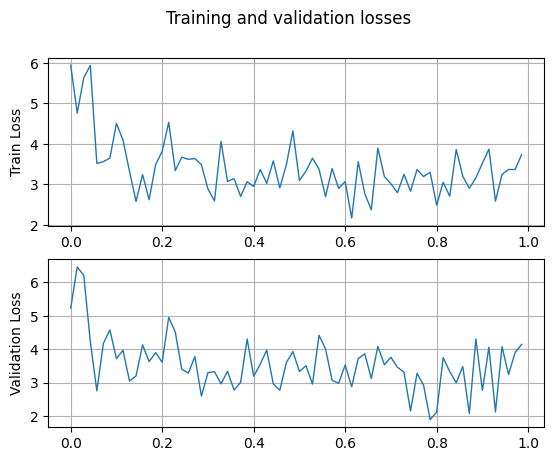

In [27]:
from utilities import plotting
reload(plotting)
plotting.plot_statistics(statistics)

In [31]:
# Save model to disk

reload(model_trainer)
model_trainer.save_model(my_model, "Another-Net", statistics)

Saved model to models/Another-Net/model_state_dict.pth
Saved statistics to models/Another-Net/statistics.pth


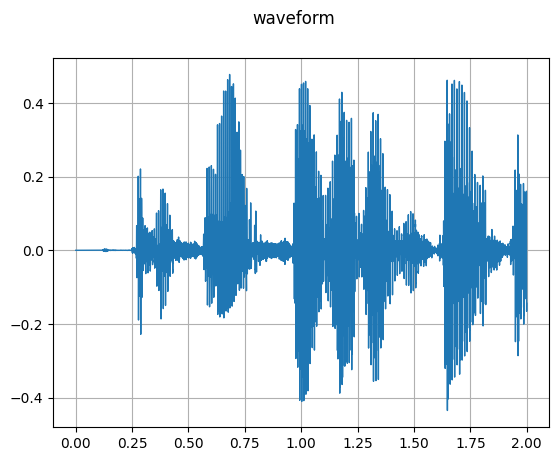

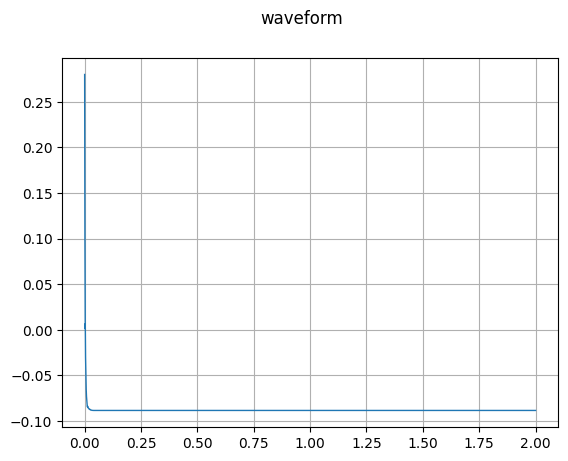

In [30]:
from utilities.plotting import plot_waveform
plot_waveform(x[0], 32000)
# plot_waveform(output_bf, 32000)
plot_waveform(output_af, 32000)

In [19]:
spectrogramer1 = torchaudio.transforms.MelSpectrogram(32000)
spectrogramer2 = torchaudio.transforms.MelSpectrogram(32000)

/opt/homebrew/lib/python3.11/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [ ]:
image1 = spectrogramer1(inp).cpu().detach()
image2 = spectrogramer1(out).cpu().detach()
image1 = F.interpolate(image1, scale_factor=.1, mode='bilinear').squeeze()
image2 = F.interpolate(image2, scale_factor=.1, mode='bilinear').squeeze()
# image1 = F.interpolate(image1, mode='linear', scale_factor=10).squeeze()
image1.shape, image2.shape

In [ ]:
plt.figure(figsize=(20,7))
plt.figure(211)
plt.imshow(image1)
plt.figure(212)
plt.imshow(image2)

In [ ]:
mystat = statistics

In [ ]:
reload(model_trainer)
stat1 = mystat
stat2 = mystat
con_stat = model_trainer.concatenate_stats(stat1, stat2)
plotting.plot_statistics(con_stat)

In [ ]:
pprint(con_stat)